# Pyroomacoustics - Generate IR dataset


In [ ]:
from sklearn import preprocessing

normalizer = preprocessing.Normalizer()
normalized_train_x = normalizer.fit_transform(x_train)
normalized_test_x = normalizer.transform(x_test)

In [ ]:
"""
This example program demonstrates the use of ray tracing
for the simulation of rooms of different sizes.
"""
from __future__ import print_function

import argparse
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile

import pyroomacoustics as pra

fs, audio_anechoic = wavfile.read("notebooks/arctic_a0010.wav")

reverb_opts = {
    "medium": {"e_abs": 0.3},
    "short": {
        "e_abs": 0.7,
    },
    "long": {"e_abs": 0.1},
}

size_opts = {
    "medium": {"mult": 2.5, "receiver_radius": 0.2},
    "large": {"mult": 5.0, "receiver_radius": 0.5},
    "small": {"mult": 1.0, "receiver_radius": 0.1},
}


def get_rir(size, reverb):
    # We construct a non-shoebox room
    pol = size_opts[size]["mult"] * np.array([[0, 0], [0, 4], [3, 2], [3, 0]]).T
    mat = pra.Material(reverb_opts[reverb]["e_abs"])
    room = pra.Room.from_corners(
        pol, fs=16000, max_order=2, materials=mat, ray_tracing=True
    )

    # Create the 3D room by extruding the 2D by a specific height
    room.extrude(size_opts[size]["mult"] * 2.5, materials=mat)

    # set the ray tracing parameters
    room.set_ray_tracing(
        receiver_radius=size_opts[size]["receiver_radius"]
    )  # , n_rays=100000)

    # Adding the source
    room.add_source(
        size_opts[size]["mult"] * np.array([1.8, 0.4, 1.6]), signal=audio_anechoic
    )

    # Adding the microphone
    R = size_opts[size]["mult"] * np.array([[0.5], [1.2], [0.5]])
    room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

    # Compute the RIR using the hybrid method
    s = time.perf_counter()
    room.compute_rir()
    print("Computation time:", time.perf_counter() - s)

    return room.rir[0][0], room


if __name__ == "__main__":
    parser = argparse.ArgumentParser(
        description=(
            "Demonstrates the use of ray tracing for rooms of "
            "different size and reverberation time"
        )
    )
    size_choices = list(size_opts.keys())
    reverb_choices = list(reverb_opts.keys())
    parser.add_argument(
        "size", choices=size_choices, default=size_choices[0], help="room size"
    )
    parser.add_argument(
        "reverb",
        choices=reverb_choices,
        default=reverb_choices[0],
        help="amount of reverberation",
    )
    args = parser.parse_args()

    rir, room = get_rir(size=args.size, reverb=args.reverb)

    room.plot(img_order=0)
    plt.title("The room we have simulated")

    # Plot and apply the RIR on the audio file
    plt.figure()
    room.plot_rir()
    plt.show()

    plt.show()

    # print('Max error (rel):', np.max(np.abs(new_rir - old_rir))/np.max(np.abs(new_rir)))
    # print('Mean error (rel):', np.mean(np.abs(new_rir - old_rir))/np.max(np.abs(new_rir)))

In [1]:
"""
In this example, we construct an L-shape 3D room. We use the same floor as in
the 2D example and extrude a 3D room from the floor with a given height.  This
is a simple way to create 3D rooms that fits most situations.  Then, we place
one source and two microphones in the room and compute the room impulse
responses.

The simulation is done using the hybrid ISM/RT simulator.
"""
from __future__ import print_function

import time

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile

import pyroomacoustics as pra

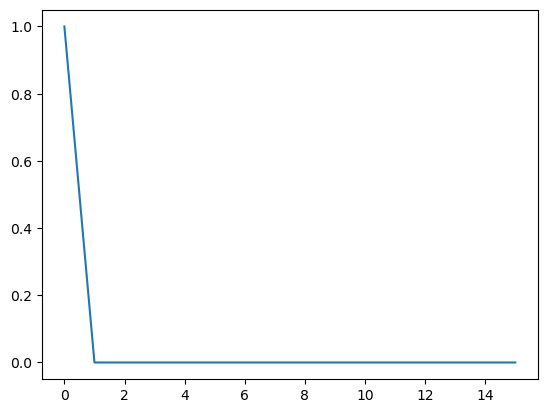

In [5]:
# Create an impulse
fs = 16000
sec = 1
impulse = np.zeros(fs*sec)
impulse[0] = 1
sci

Done in 1.6203927993774414 seconds.
RT60: 0.913375


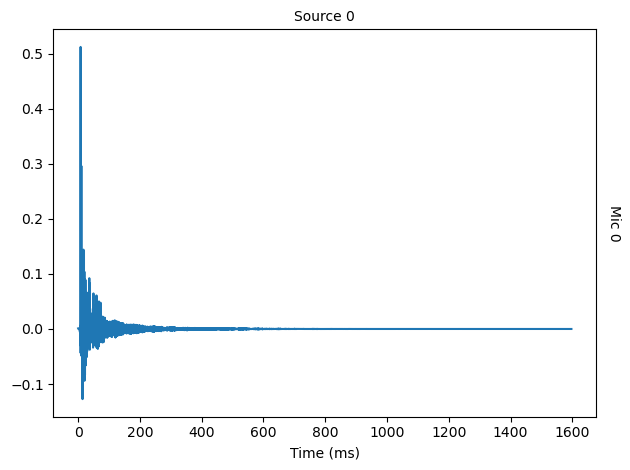

In [4]:
# Create the 2D L-shaped room from the floor polygon
pol = np.array([[0, 0], [0, 10], [7.5, 10], [7.5, 6], [5, 6], [5, 0]]).T
r_absor = 0.1
mat = pra.Material(0.15, 0.1)
room = pra.Room.from_corners(
    pol,
    fs=16000,
    # absorption=r_absor,
    materials=mat,
    max_order=3,
    ray_tracing=True,
    air_absorption=True,
)

# # Create the 3D room by extruding the 2D by 10 meters
height = 10.0
room.extrude(height, materials=mat)

room.set_ray_tracing(receiver_radius=0.5)

# # Add a source somewhere in the room
fs, audio_anechoic = wavfile.read("input_samples/cmu_arctic_us_aew_a0001.wav")
room.add_source([1.5, 1.7, 1.6], signal=audio_anechoic)

# Add a microphone
room.add_microphone([3.0, 2.25, 0.6])

# Use the following function to compute the rir using either 'ism' method, 'rt' method, or 'hybrid' method
chrono = time.time()
room.compute_rir()
print("Done in", time.time() - chrono, "seconds.")
print("RT60:", room.measure_rt60()[0, 0])

room.plot_rir()
plt.show()
room.simulate()
audio_reverb = room.mic_array.to_wav("output_samples/aaa.wav", norm=True, bitdepth=np.int16)

In [6]:
rir_storage = room.rir

In [14]:
type(rir_storage[0][0])

numpy.ndarray

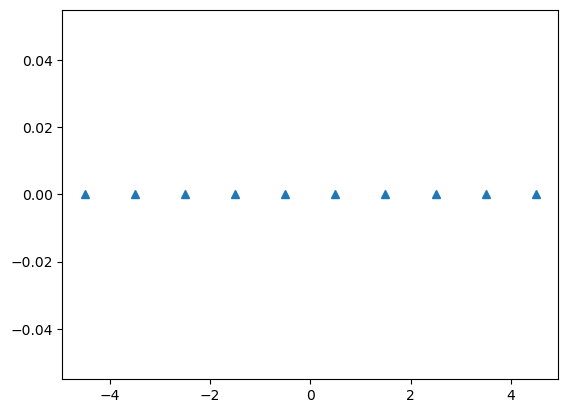

In [23]:
spacing = pra.beamforming.linear_2D_array([0,0], 10, 0, 1)
ax = plt.figure().add_subplot()
ax.plot(spacing[0,:],spacing[1,:], '^')
plt.show()

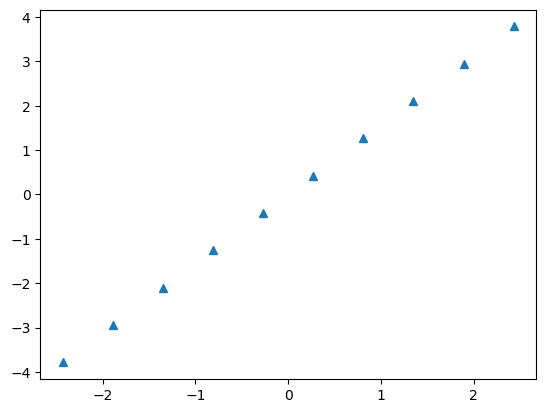